# Data analysis for Chapter "Global optima and fixed points"

This notebook ....

In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *


In [2]:
# Relevant dirs and file names

# relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_20231108_process_results'
data_file_name = f'{data_set_name}.csv.tar.gz'

tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

## Loading data

In [3]:

re_data = load_re_data(data_dir, data_file_name)
#display(re_data)
#display(re_data.columns)

In [4]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 2047
   Number of dialectical structures: 8
   Overall number of initial commitments: 20
   Sentence-pools: [6 7]
   Models: ['StandardGlobalReflectiveEquilibrium'
 'StandardGlobalReflectiveEquilibriumLinearG'
 'StandardLocalReflectiveEquilibrium'
 'StandardLocalReflectiveEquilibriumLinearG']




## Table

In [5]:
# We want to summarise branches that belong to one ensemble run (i.e., to one set of initial coms, model name etc.)
# into one row.
# Basic idea by using data_frame.duplicate:
# We remove duplicate rows (and keep the first one) of the subdataframe of those cols with identical values that make up branches 
# that belong together and pick the first element of the remaining cols (which should be the same for all 
# cols that matte for subsequent calculations). We then use the resulting (unchanged) index to subset the whole data frame.

# Cols that should have identical values for all branches (and only for those) that belong to one branching model run
cols_group_branches = ['model_name','ds','init_coms','weight_account', 'weight_systematicity', 'weight_faithfulness'] 

#relevant_cols = ['fixed_points','fixed_point_coms', 'global_optima','go_fixed_point']

re_data_collapsed_branches = re_data.loc[re_data[cols_group_branches].drop_duplicates().index]


In [6]:
# number of go that are fp
re_data_collapsed_branches['n_go_fp'] = re_data_collapsed_branches.apply(lambda x: sum(x['go_fixed_point']) , axis=1)

# just to check: should be the same values as 'n_go_fixed_point'
re_data_collapsed_branches['n_fp_go'] = re_data_collapsed_branches.apply(lambda x: sum(x['fp_global_optimum']) , axis=1)


#display(re_data_collapsed_branches[relevant_cols])

# aggregate values among models
agg_funs = {
    'n_branches': 'sum',
    'n_fixed_points': 'sum',
    'n_global_optima': 'sum',
    'n_fp_go': 'sum',
    'n_go_fp': 'sum',   
}

result_df = re_data_collapsed_branches.groupby('model_name').agg(agg_funs).reset_index()

# calcualte relative shares
result_df['rel_go_fp'] = result_df.apply(lambda x: round(x['n_go_fp']/x['n_global_optima']*100,1), axis=1)
result_df['rel_fp_go'] = result_df.apply(lambda x: round(x['n_go_fp']/x['n_fixed_points']*100,1), axis=1)
display(result_df)

# Preparing the dataframe for csv export
model_short_names = {'StandardGlobalReflectiveEquilibrium':'GlobalRE',
                     'StandardLocalReflectiveEquilibrium':'LocalRE',
                     'StandardGlobalReflectiveEquilibriumLinearG': 'LinearGlobalRE',
                     'StandardLocalReflectiveEquilibriumLinearG': 'LinearLocalRE'
                    }
# Adding model short names
result_df['model_short_name'] = result_df['model_name'].map(lambda x: model_short_names[x])

# Changing col names for readability
cols_for_tables = {'model_short_name':'Model',
                   'rel_go_fp': '% of fixed points in global optima',
                   'rel_fp_go': '% of global optima in fixed points',
                  }
display(result_df.rename(columns=cols_for_tables))
# Exporting relevant cols

result_df[['model_short_name','rel_go_fp','rel_fp_go']].rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, 'table_go_fp.csv'), index=False)

,model_name,n_branches,n_fixed_points,n_global_optima,n_fp_go,n_go_fp,rel_go_fp,rel_fp_go
0,StandardGlobalReflectiveEquilibrium,438,417,575,327,327,56.9,78.4
1,StandardGlobalReflectiveEquilibriumLinearG,478,478,846,397,397,46.9,83.1
2,StandardLocalReflectiveEquilibrium,665,481,575,300,300,52.2,62.4
3,StandardLocalReflectiveEquilibriumLinearG,466,287,846,234,234,27.7,81.5


,model_name,n_branches,n_fixed_points,n_global_optima,n_fp_go,n_go_fp,% of fixed points in global optima,% of global optima in fixed points,Model
0,StandardGlobalReflectiveEquilibrium,438,417,575,327,327,56.9,78.4,GlobalRE
1,StandardGlobalReflectiveEquilibriumLinearG,478,478,846,397,397,46.9,83.1,LinearGlobalRE
2,StandardLocalReflectiveEquilibrium,665,481,575,300,300,52.2,62.4,LocalRE
3,StandardLocalReflectiveEquilibriumLinearG,466,287,846,234,234,27.7,81.5,LinearLocalRE


## Venn Diagramms

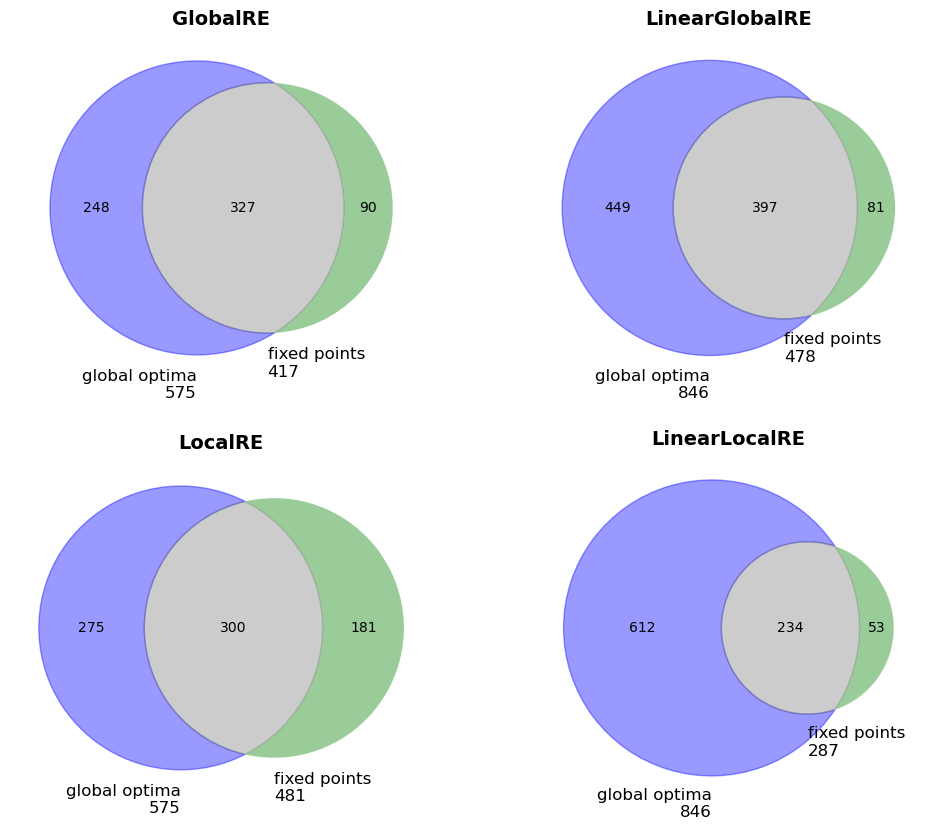

In [7]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

plt.rcParams["figure.figsize"] = (12,10)
#plt.suptitle("Share of global optima and fixed points")

for i, row in result_df.iterrows():

    plt.subplot(2,2,i+1)

    tup = (row["n_global_optima"]-row["n_go_fp"], row["n_fixed_points"]-row["n_go_fp"], row["n_go_fp"])

    v = venn2(tup, ("global optima" + '\n' + str(row["n_global_optima"]), 
                "fixed points" + '\n' + str(row["n_fixed_points"])))

    v.get_patch_by_id('10').set_color("b")
    v.get_patch_by_id('11').set_color("grey")

    plt.title(row["model_short_name"], fontweight='bold', fontsize=14)

plt.savefig(path.join(figures_output_dir, 'go-fp-venn.pdf'), bbox_inches='tight')
plt.savefig(path.join(figures_output_dir, 'go-fp-venn.png'), bbox_inches='tight')

plt.show()

## Deprecated (to be removed later on)

In [102]:
# The original suggestion to calculate mean number of fixed point among go, which has a double counting problem due to
# the multiplicity of branches. 

# Is this correct? What about the multiplicity due to branching? The possible double-counting wouldn't matter 
# only if there is always the same number of branches, right? 
re_data['rel_global_optima_that_are_fixed_points'] = re_data['go_fixed_point'].map(sum)/re_data['go_fixed_point'].map(len)
print('In', len(re_data[re_data['rel_global_optima_that_are_fixed_points'] == 1]),
      'out of', len(re_data),'(=', "{:2.1f}".format( len(re_data[re_data['rel_global_optima_that_are_fixed_points'] == 1])/len(re_data)*100),
      '%) processes are all global optima fixed points.')

print('\n')
print("Mean relative share of global optima that are fixed points:")
display(re_data.groupby(['model_name']).mean()[['rel_global_optima_that_are_fixed_points']])


In 107 out of 197 (= 54.3 %) processes are all global optima fixed points.


Mean relative share of global optima that are fixed points:


/tmp/ipykernel_452939/2460446498.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(re_data.groupby(['model_name']).mean()[['rel_global_optima_that_are_fixed_points']])


,rel_global_optima_that_are_fixed_points
model_name,
GlobalNumpyReflectiveEquilibrium,0.885714
LocalStandardReflectiveEquilibrium,0.118056
StandardGlobalReflectiveEquilibriumLinearG,0.955009
StandardLocalReflectiveEquilibriumLinearG,0.066667


In [103]:
# Alternative suggestion to summarise branches that belong to the same branching model run (instead of using df.duplicate)
# Idea: groupby cols that "individuate" branches that belong to the same model run

cols_group_branches = ['model_name','ds','init_coms','weight_account', 'weight_systematicity', 'weight_faithfulness'] 
relevant_cols = ['fixed_points','fixed_point_coms', 'global_optima','go_fixed_point']
#tmp = re_data.groupby(cols_group_branches).agg(lambda x: len(set(x)) <= 1)
#tmp = re_data.groupby(cols_group_branches)[relevant_cols].agg(lambda x: set(x))
#display(tmp.columns)
#display(tmp.head())

# A:
# Idea: We group row according to those cols that individuate branches that belong together and pick the first
# elelement of the remaining cols (which should be the same for all cols that matte for subsequent calculations).
re_data_group_branches = re_data.groupby(cols_group_branches)[relevant_cols].agg(lambda x: list(x)[0])
#display(re_data_group_branches.reset_index()[relevant_cols])
#display(re_data_group_branches.reset_index()[['fixed_points', 'global_optima']])


# The calculation is the same as in the original suggestion:
re_data_group_branches['rel_global_optima_that_are_fixed_points'] = re_data_group_branches['go_fixed_point'].map(sum)/re_data_group_branches['go_fixed_point'].map(len)
print('In', len(re_data_group_branches[re_data_group_branches['rel_global_optima_that_are_fixed_points'] == 1]),
      'out of', len(re_data_group_branches),'(=', "{:2.1f}".format( len(re_data_group_branches[re_data_group_branches['rel_global_optima_that_are_fixed_points'] == 1])/len(re_data)*100),
      '%) processes are all global optima fixed points.')

print('\n')
print("Mean relative share of global optima that are fixed points:")
display(re_data_group_branches.groupby(['model_name']).mean()[['rel_global_optima_that_are_fixed_points']])

In 18 out of 48 (= 9.1 %) processes are all global optima fixed points.


Mean relative share of global optima that are fixed points:


/tmp/ipykernel_452939/3144989660.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(re_data_group_branches.groupby(['model_name']).mean()[['rel_global_optima_that_are_fixed_points']])


,rel_global_optima_that_are_fixed_points
model_name,
GlobalNumpyReflectiveEquilibrium,0.863095
LocalStandardReflectiveEquilibrium,0.076389
StandardGlobalReflectiveEquilibriumLinearG,0.722553
StandardLocalReflectiveEquilibriumLinearG,0.083333
